In [1]:
OUTDATED_IGNORE=1

import pandas as pd 
import pingouin as pg 
import numpy as np 
import matplotlib.pyplot as plt
import pickle

#import  statsmodels.formula.api as smf 
#import statsmodels.api as sm

### READ IN DATA 


In [2]:
## read in median global FA metrics 
df = pd.read_csv('../../DerivedData/extracted_metrics/global_cortical_diffusion_metrics_median.csv', index_col=0)

## to get other clinical information
info = pd.read_csv('../../DerivedData/cohortA_subjects_clinical.csv', index_col=0)
df = pd.merge(df, info, on=['subject_id'])
df['group'] = 'FT'
df.loc[df['GA_birth'] < 37, 'group'] = 'PT'
    
## I have extracted the values per hemisphere
# combine them together:
#metrics = ['FA', 'L1', 'RD', 'MD']
metrics = ['FA']
hemispheres = ['left', 'right']
for metric in metrics:
    for i, row in df.iterrows():
        df.loc[i,metric] = np.mean([row['left_{}'.format(metric)], 
                                   row['right_{}'.format(metric)]])
        
## to select only subjects belonging to the given cohort 
with open('../../DerivedData/cohorts_subjects_list.pickle', 'rb') as handle:
    cohorts = pickle.load(handle)

/volatile/miniconda3/envs/ohbm/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


## Piecewise linear regression 
In this way, the continuity is not enforced. The knot is selected a priori and the two segments are fitted independently. 

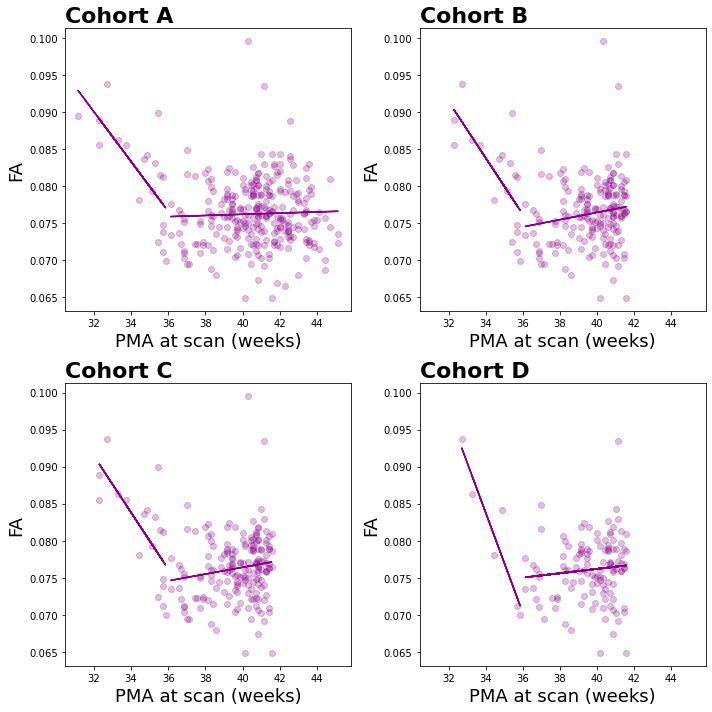

In [3]:
fig, axs = plt.subplots(2,2, figsize=(10,10), sharex=True, sharey=True)#, sharey='row')
axs = axs.ravel()
#for f, cohort in enumerate(cohorts.keys()):
for f, cohort in enumerate(['A', 'B', 'C', 'D']):
    #print('Cohort {}:'.format(cohort))
    sub_df = df[df.subject_id.isin(cohorts[cohort])]

    metric = 'FA'
    axs[f].scatter(sub_df['PMA_scan'].values, sub_df[metric].values, c='darkmagenta', alpha=0.25)

    knot = 36

    m, b = np.polyfit(sub_df[sub_df.PMA_scan < knot]['PMA_scan'].values, sub_df[sub_df.PMA_scan < knot][metric].values, deg=1)
    axs[f].plot(sub_df[sub_df.PMA_scan < knot]['PMA_scan'].values, b + m*sub_df[sub_df.PMA_scan < knot]['PMA_scan'].values, linestyle='-', c='darkmagenta')

    m, b = np.polyfit(sub_df[sub_df.PMA_scan >= knot]['PMA_scan'].values, sub_df[sub_df.PMA_scan >=  knot][metric].values, deg=1)
    axs[f].plot(sub_df[sub_df.PMA_scan >= knot]['PMA_scan'].values, b + m*sub_df[sub_df.PMA_scan >=  knot]['PMA_scan'].values, linestyle='-', c='darkmagenta')

    axs[f].xaxis.set_tick_params(which='both', labelbottom=True)
    axs[f].yaxis.set_tick_params(which='both', labelbottom=True)
    axs[f].set_xlabel('PMA at scan (weeks)', fontsize=18)
    axs[f].set_ylabel(f'FA', fontsize=18)
    axs[f].set_title('Cohort {}'.format(cohort), fontsize=22, loc='left', fontweight='bold')

plt.tight_layout()
#plt.savefig('../../Results/figures/cohort_descriptions/lr_global_FA_with_PMA_cohorts.jpg', dpi=500)
plt.show()

This creates weird (although correct for what we ask from the fitting) gaps which are unlikely to be biologically plausible. We prefer to use a continuous piecewise linear regression instead 

## CONTINUOUS PIECEWISE LINEAR REGRESSION 
This is using **pwfl** python package <br>
More info on the package/usage is here: https://jekel.me/2017/Fit-a-piecewise-linear-function-to-data/

In [4]:
# Uncomment to install: 
#!pip install pwlf
import pwlf

### testing on the cohort A only - no enforcement of knot position

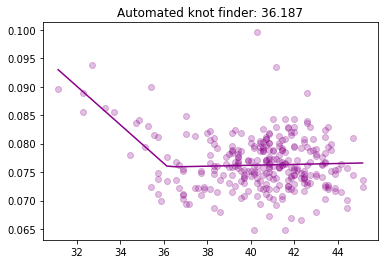

In [5]:
sub_df = df[df.subject_id.isin(cohorts['A'])]

# initiate the model 
myPWLF = pwlf.PiecewiseLinFit(sub_df['PMA_scan'].values,sub_df['FA'].values)
# fit into 2 line segments 
res = myPWLF.fit(2)
# predict the values for PMA_scan (after sorting for plotting)
inX = np.sort(sub_df['PMA_scan'].values)
yHat = myPWLF.predict(inX)

plt.scatter(sub_df['PMA_scan'].values, sub_df[metric].values, c='darkmagenta', alpha=0.25)
plt.plot(inX, yHat, '-', c='darkmagenta' )
plt.title('Automated knot finder: {:.3f}'.format(res[1]))
plt.show()

Ultimatelly, this might be a more appropriate way of correcting, i.e. finding the best knot given the inputs. However, this might turn into nightmare very quickly given we want to treat each cohort/region independently, leading to numerous different inflection points. <br>Although again, **these might be more appropriate as regions do not develop homogeneously with time!**<br><br> Nevertheless, we are going to try to find the 'best' inflection point before the corrections. For this we: <br>
- use cohort A subjects global FA 
- try different fixed inflection point 
- evaluate BIC and AIC scores given the residuals of those models 
- select the inflection point that leads to lowest AIC/BIC
- use this in all future corrections 

In [6]:
def get_AIC_BIC(residuals, method='LL'):
    ## calculates AIC and BIC metrics, there are two ways, 
    ## either using residuals directly or mse which is connected
    
    mse = np.sum(residuals**2)/len(residuals) 
    n=len(residuals)
    k=2
    
    ## LL way
    if method == 'LL':
        ll = -(n * 1/2) * (1 + np.log(2 * np.pi)) - (n / 2) * np.log(residuals.dot(residuals) / n)
        BIC = (-2 * ll) + (k * np.log(n))
        AIC = (-2 * ll) + (2 * k)
        return AIC, BIC
    
    ## mse way
    elif method == 'mse':
        aic = n * np.log(mse) + 2 * k
        bic = n * np.log(mse) + k * np.log(n)
    
        return aic, bic
    

In [7]:
sub_df = df[df.subject_id.isin(cohorts['A'])]

## range of inflection points 
rg = np.arange(35, 43)
print('Tested inflection points: {}'.format(rg))
print('\n'.format(rg))
# your desired line segment end locations

aic_res = []
bic_res = []

for middle in rg:
    
    ## set knot locations
    x0 = np.array([min(sub_df['PMA_scan'].values), middle, max(sub_df['PMA_scan'].values)])
    
    ## fit the model
    myPWLF = pwlf.PiecewiseLinFit(sub_df['PMA_scan'].values,sub_df['FA'].values)
    myPWLF.fit_with_breaks(x0)

    ## predict PMA at scan && compute residuals (== real FA - predicted FA)
    yHat = myPWLF.predict(sub_df['PMA_scan'].values)
    residuals = sub_df['FA'].values - yHat
    
    ## compute AIC, BIC 
    AIC, BIC = get_AIC_BIC(residuals=residuals)
    aic_res.append(AIC)
    bic_res.append(BIC)
    
    print('Inflection point {}: AIC {:.3f}, BIC {:.3f}'.format(middle, AIC, BIC))
    
print('\n'.format(rg))

for metric, best in zip(['AIC', 'BIC'], [aic_res, bic_res]):
    print('Optimal inflection point based on {}: {}'.format(metric, rg[np.argmin(best)]))

Tested inflection points: [35 36 37 38 39 40 41 42]


Inflection point 35: AIC -2364.681, BIC -2357.307
Inflection point 36: AIC -2372.054, BIC -2364.680
Inflection point 37: AIC -2368.752, BIC -2361.378
Inflection point 38: AIC -2357.926, BIC -2350.552
Inflection point 39: AIC -2348.266, BIC -2340.892
Inflection point 40: AIC -2341.487, BIC -2334.113
Inflection point 41: AIC -2337.263, BIC -2329.890
Inflection point 42: AIC -2336.130, BIC -2328.756


Optimal inflection point based on AIC: 36
Optimal inflection point based on BIC: 36


To visualise the fits: 

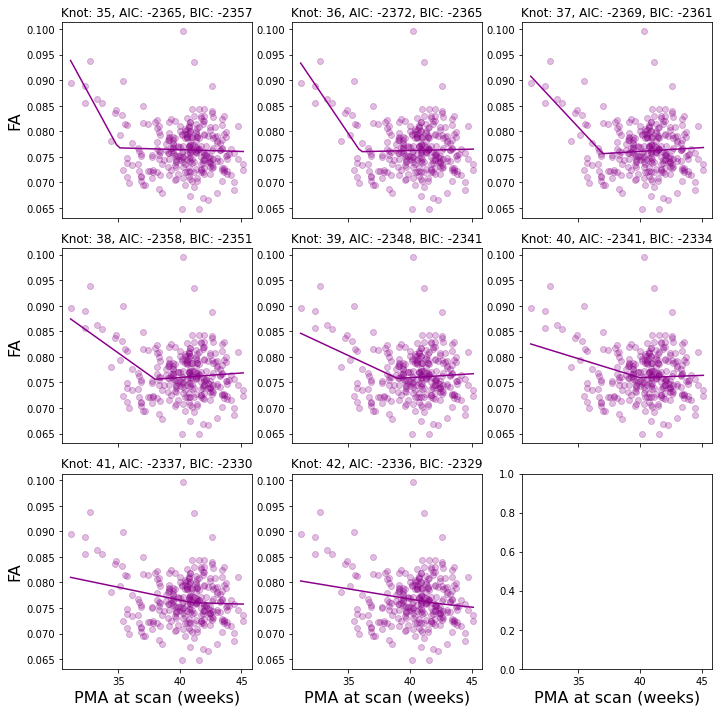

In [8]:
fig, axs = plt.subplots(3,int(len(rg)/3)+1, figsize=(10,10), sharex=True)#, sharey='row')
axs = axs.ravel()

for f, middle in enumerate(rg):
    x0 = np.array([min(sub_df['PMA_scan'].values), middle, max(sub_df['PMA_scan'].values)])
    myPWLF = pwlf.PiecewiseLinFit(sub_df['PMA_scan'].values,sub_df['FA'].values)
    myPWLF.fit_with_breaks(x0)
    
    inX = np.sort(sub_df['PMA_scan'].values)
    yHat = myPWLF.predict(inX)
    
    axs[f].scatter(sub_df['PMA_scan'].values, sub_df['FA'].values, c='darkmagenta', alpha=0.25)
    axs[f].plot(inX, yHat, '-', c='darkmagenta' )
    
    axs[f].set_title('Knot: {}, AIC: {:.0f}, BIC: {:.0f}'.format(middle, aic_res[f], bic_res[f]))
    
for a in [6,7,8]:    
    axs[a].set_xlabel('PMA at scan (weeks)', fontsize=16)
for a in [0,3,6]:
    axs[a].set_ylabel(f'FA', fontsize=16)
    
plt.tight_layout()
#plt.savefig('../../Results/figures/cohort_descriptions/lr_global_FA_with_PMA_cohorts.jpg', dpi=500)
plt.show()

### PLOTTING the results of fixes knot=36 on 4 cohorts

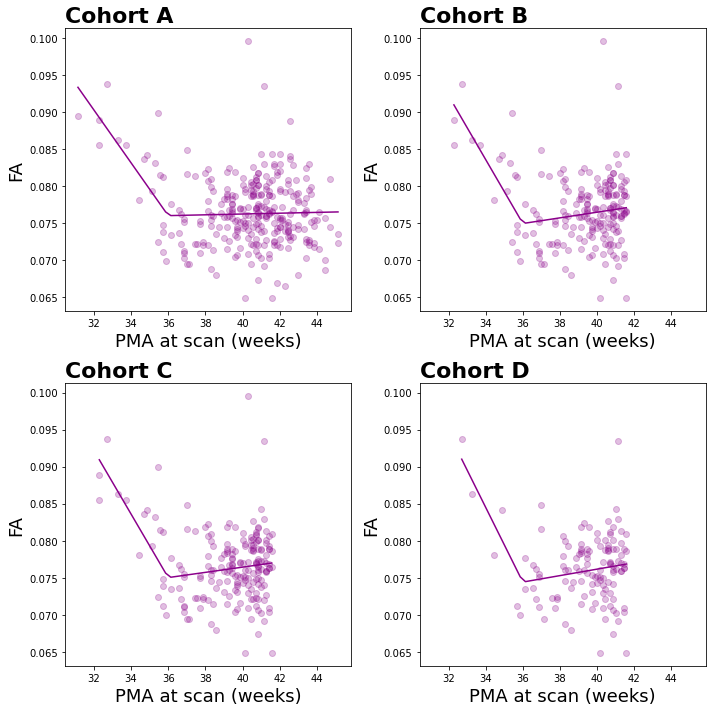

In [9]:
fig, axs = plt.subplots(2,2, figsize=(10,10), sharex=True, sharey=True)#, sharey='row')
axs = axs.ravel()
#for f, cohort in enumerate(cohorts.keys()):
for f, cohort in enumerate(['A', 'B', 'C', 'D']):
    #print('Cohort {}:'.format(cohort))
    sub_df = df[df.subject_id.isin(cohorts[cohort])]

    metric = 'FA'
    
    axs[f].scatter(sub_df['PMA_scan'].values, sub_df[metric].values, c='darkmagenta', alpha=0.25)

    x0 = np.array([min(sub_df['PMA_scan'].values), 36, max(sub_df['PMA_scan'].values)])
    myPWLF = pwlf.PiecewiseLinFit(sub_df['PMA_scan'].values,sub_df['FA'].values)
    myPWLF.fit_with_breaks(x0)
    
    inX = np.sort(sub_df['PMA_scan'].values)
    yHat = myPWLF.predict(inX)
    
    axs[f].plot(inX, yHat, '-', c='darkmagenta' )

    axs[f].xaxis.set_tick_params(which='both', labelbottom=True)
    axs[f].yaxis.set_tick_params(which='both', labelbottom=True)
    axs[f].set_xlabel('PMA at scan (weeks)', fontsize=18)
    axs[f].set_ylabel(f'FA', fontsize=18)
    axs[f].set_title('Cohort {}'.format(cohort), fontsize=22, loc='left', fontweight='bold')

plt.tight_layout()
#plt.savefig('../../Results/figures/cohort_descriptions/lr_global_FA_with_PMA_cohorts.jpg', dpi=500)
plt.show()

## AGE CORRECTION propre
Test age correction on the global FA, i.e. how does the data look after correcting for PMA at scan?

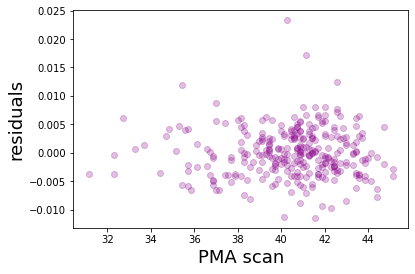

In [14]:
## example cohort A
sub_df = df[df.subject_id.isin(cohorts['A'])]

middle = 36
## set knot locations
x0 = np.array([min(sub_df['PMA_scan'].values), middle, max(sub_df['PMA_scan'].values)])
    
## fit the model
myPWLF = pwlf.PiecewiseLinFit(sub_df['PMA_scan'].values,sub_df['FA'].values)
myPWLF.fit_with_breaks(x0)

## predict PMA at scan && compute residuals (== real FA - predicted FA)
yHat = myPWLF.predict(sub_df['PMA_scan'].values)
residuals = sub_df['FA'].values - yHat

plt.scatter(sub_df['PMA_scan'].values, residuals,  c='darkmagenta', alpha=0.25)
plt.ylabel('residuals', fontsize=18)
plt.xlabel('PMA scan', fontsize=18)

plt.show()

Looks OK. Try same but per region! 

In [15]:
### median FA regions 
diff = pd.read_csv('../../DerivedData/extracted_metrics/neonat_segmentation_diffusion_metric_median.csv', index_col=0)

FA_cols = [col for col in diff.columns if 'FA' in col]
FA_cols.extend(['subject_id'])

new_df = sub_df.copy()
new_df = pd.merge(new_df, diff[FA_cols], on=['subject_id'])

FA_cols.extend(['PMA_scan'])
inX = new_df[FA_cols].values

In [16]:
inflection = 36

outX = np.zeros_like(inX)

for idx, col in enumerate(FA_cols[:-2]):
    
    x0 = np.array([min(inX[:,-1]), inflection, max(inX[:,-1])])    
    col_median = np.nanmedian(inX[:,idx].astype(np.float32))
    indices = np.where(pd.isna(inX[:,idx]))
    for n in indices: 
        inX[n, idx] = col_median
    
    ### fit the corrector
    myPWLF = pwlf.PiecewiseLinFit(inX[:,-1].astype(np.float32), inX[:,idx].astype(np.float32))
    myPWLF.fit_with_breaks(x0)
    
    yHat = myPWLF.predict(inX[:,-1])
    res = inX[:,idx] - yHat
    outX[:,idx] = res
    

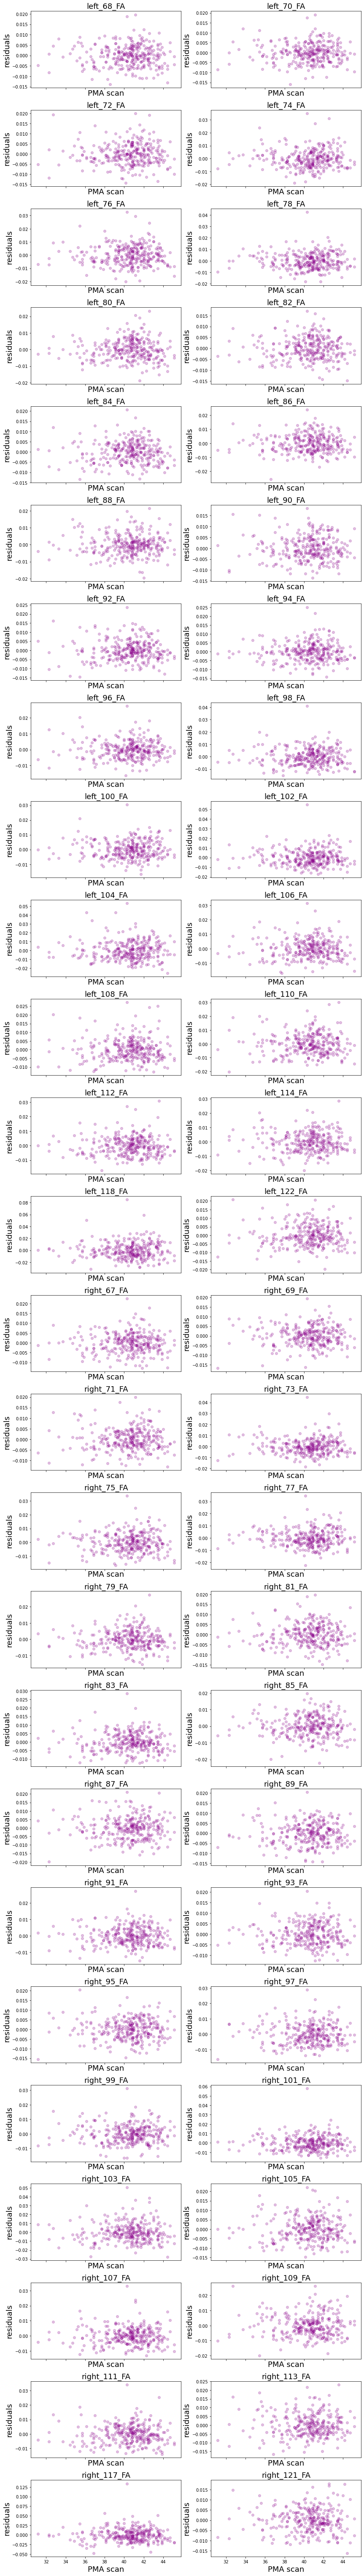

In [17]:
num_rows = len(FA_cols[:-2])/2.

fig, axs = plt.subplots(int(num_rows),2, figsize=(12,85), sharex=True, sharey=False)#, sharey='row')
axs = axs.ravel()


for f, region in enumerate(FA_cols[:-2]) :
    
    axs[f].scatter( inX[:,-1], outX[:,f],  c='darkmagenta', alpha=0.25)
    axs[f].set_ylabel('residuals', fontsize=18)
    axs[f].set_xlabel('PMA scan', fontsize=18)
    axs[f].set_title(region, fontsize=18)
    
plt.tight_layout()
plt.show()

Plot distribution of residuals per region:

In [18]:
scheme = pd.read_csv('../../SourceData/atlas_labelling_scheme.csv')
lbs = [name.split('_')[1] for name in FA_cols[:-2]]
names = [scheme[scheme.Label == int(l)]['Abbreviation'].values[0] + ' ' +  scheme[scheme.Label == int(l)]['Hemisphere'].values[0]for l in lbs]

In [19]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color='darkgray')
    plt.setp(bp['caps'], color='darkgray')
    plt.setp(bp['medians'], color=color)
    plt.setp(bp['fliers'], color='darkgray', alpha=0.5)

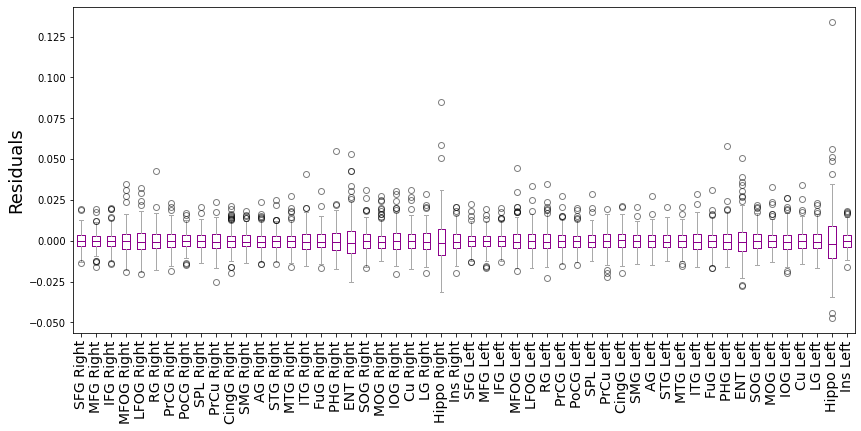

In [20]:
plt.figure(figsize=(14,6))
bpl = plt.boxplot([ outX[:, idx] for idx in range(len(FA_cols[:-2]))], positions= range(len(FA_cols[:-2])), 
            labels=names, )
set_box_color(bpl, 'darkmagenta')

plt.xticks(rotation=90, fontsize=14)
plt.ylabel('Residuals', fontsize=18 )
plt.show()

## try to add predicted at TEA values /region to make it look better 

In [21]:
### median FA regions 
diff = pd.read_csv('../../DerivedData/extracted_metrics/neonat_segmentation_diffusion_metric_median.csv', index_col=0)

FA_cols = [col for col in diff.columns if 'FA' in col]
FA_cols.extend(['subject_id'])

new_df = sub_df.copy()
new_df = pd.merge(new_df, diff[FA_cols], on=['subject_id'])

FA_cols.extend(['PMA_scan'])
inX = new_df[FA_cols].values

In [34]:
inflection = 36

outX = np.zeros_like(inX)

for idx, col in enumerate(FA_cols[:-2]):
    
    x0 = np.array([min(inX[:,-1]), inflection, max(inX[:,-1])])    
    col_median = np.nanmedian(inX[:,idx].astype(np.float32))
    indices = np.where(pd.isna(inX[:,idx]))
    for n in indices: 
        inX[n, idx] = col_median
    
    ### fit the corrector
    myPWLF = pwlf.PiecewiseLinFit(inX[:,-1].astype(np.float32), inX[:,idx].astype(np.float32))
    myPWLF.fit_with_breaks(x0)
    
    ages = np.empty_like(inX[:,-1])
    ages[:] = 40
    
    TEA = myPWLF.predict(ages)
    yHat = myPWLF.predict(inX[:,-1])
    
    res = inX[:,idx] - yHat
    
    outX[:,idx] = res + TEA
    

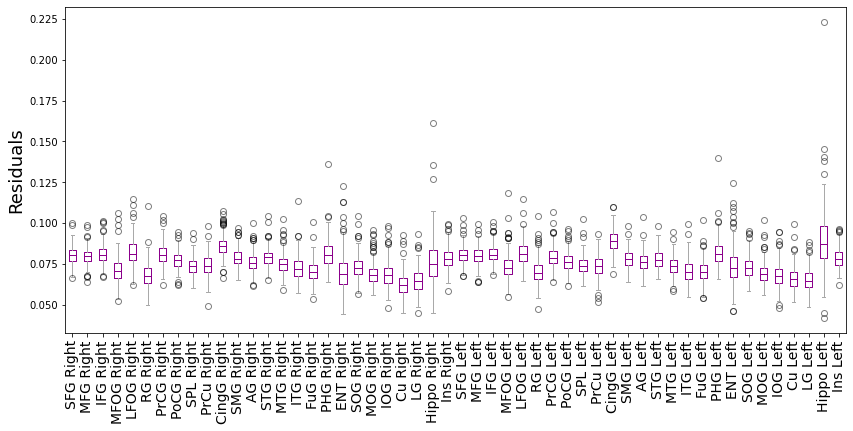

In [35]:
plt.figure(figsize=(14,6))
bpl = plt.boxplot([ outX[:, idx] for idx in range(len(FA_cols[:-2]))], positions= range(len(FA_cols[:-2])), 
            labels=names, )
set_box_color(bpl, 'darkmagenta')

plt.xticks(rotation=90, fontsize=14)
plt.ylabel('Residuals', fontsize=18 )
plt.show()

### Diffusion metrics 

In [66]:
## median FA regions 
diff = pd.read_csv('../../DerivedData/extracted_metrics/neonat_segmentation_diffusion_metric_median.csv', index_col=0)

FA_cols = [col for col in diff.columns if 'FA' in col]
FA_cols.extend(['subject_id'])

new_df = sub_df.copy()
new_df = pd.merge(new_df, diff[FA_cols], on=['subject_id'])

FA_cols.extend(['PMA_scan'])
inX = new_df[FA_cols].values


In [74]:
inflection = 36

outX_res = np.zeros_like(inX)
outX_res_40 = np.zeros_like(inX)

for idx, col in enumerate(FA_cols[:-2]):
    
    x0 = np.array([min(inX[:,-1]), inflection, max(inX[:,-1])])    
    col_median = np.nanmedian(inX[:,idx].astype(np.float32))
    indices = np.where(pd.isna(inX[:,idx]))
    for n in indices: 
        inX[n, idx] = col_median
    
    ### fit the corrector
    myPWLF = pwlf.PiecewiseLinFit(inX[:,-1].astype(np.float32), inX[:,idx].astype(np.float32))
    myPWLF.fit_with_breaks(x0)
    
    ages = np.empty_like(inX[:,-1])
    ages[:] = 40
    
    TEA = myPWLF.predict(ages)
    yHat = myPWLF.predict(inX[:,-1])
    
    res = inX[:,idx] - yHat
    
    outX_res[:,idx] = res
    outX_res_40[:,idx] = res + TEA

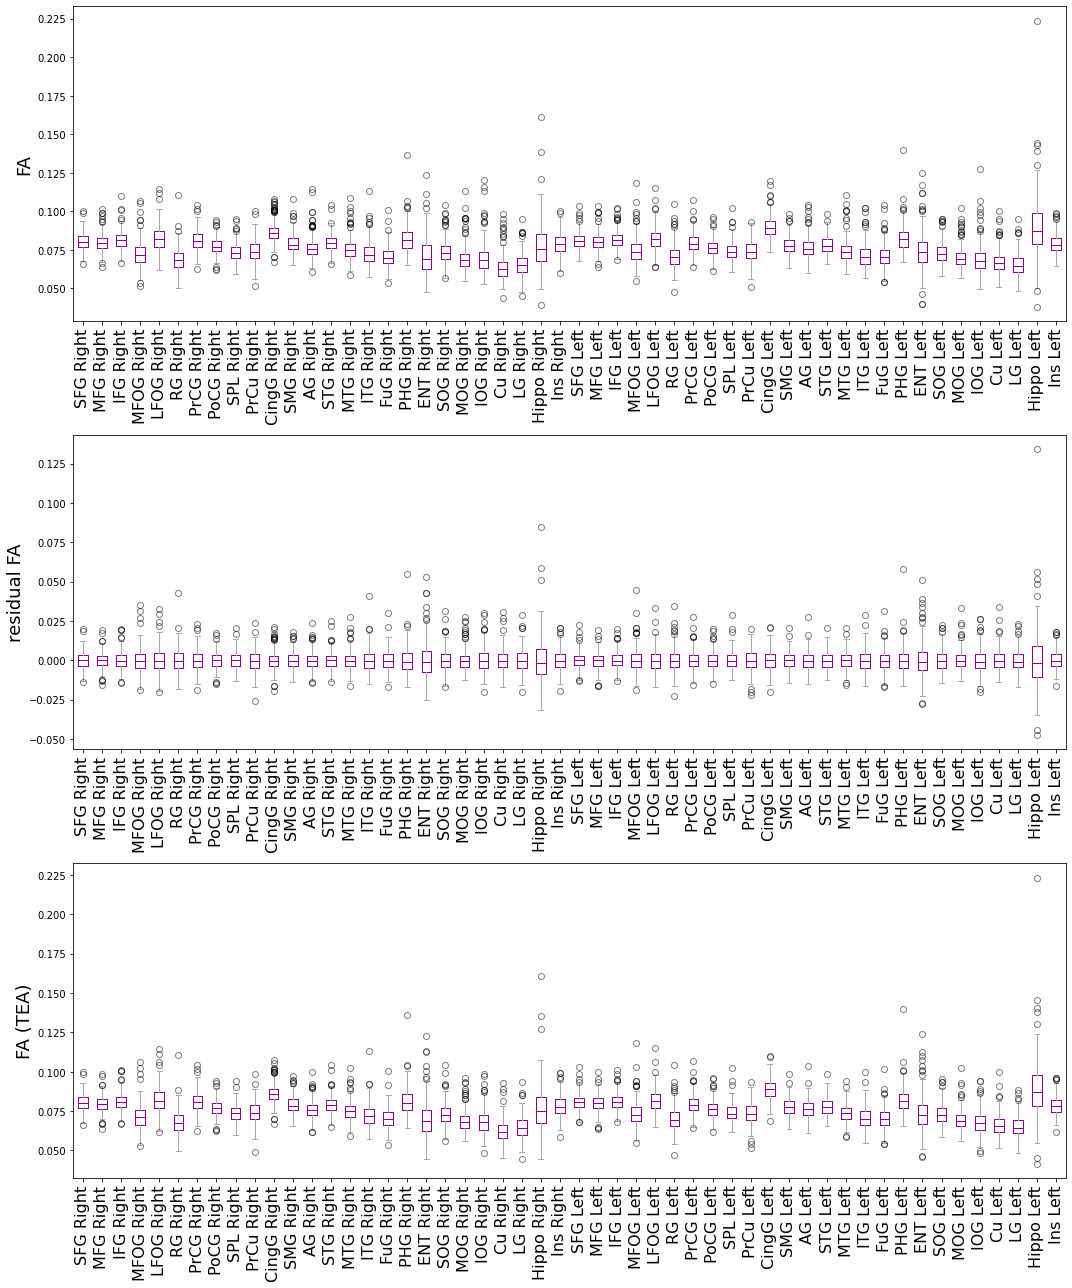

In [80]:
fig, axs = plt.subplots(3,1,figsize=(15,18))

for idx in FA_cols[:-2]:
    new_df[idx].fillna(new_df[idx].median(), inplace=True)

bpl = axs[0].boxplot([ new_df[idx].values for idx in FA_cols[:-2]], positions= range(len(FA_cols[:-2])), 
            labels=names, )
set_box_color(bpl, 'darkmagenta')

bpl = axs[1].boxplot([ outX_res[:, idx] for idx in range(len(FA_cols[:-2]))], positions= range(len(FA_cols[:-2])), 
            labels=names, )
set_box_color(bpl, 'darkmagenta')

bpl = axs[2].boxplot([ outX_res_40[:, idx] for idx in range(len(FA_cols[:-2]))], positions= range(len(FA_cols[:-2])), 
            labels=names, )
set_box_color(bpl, 'darkmagenta')


for ax, label in zip(axs, ['FA', 'residual FA', 'FA (TEA)']):
    #axs[0].set_xticks( fontsize=14)
    ax.xaxis.set_tick_params(labelrotation=90, labelsize=16)
    ax.set_ylabel(label, fontsize=18 )


plt.tight_layout()
plt.savefig('../../Results/figures/FA_distribution_cohortA.png', dpi=500, facecolor='white', transparent=False)
plt.show()